In [1]:
import os
import random
import gc
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

In [2]:
# Set random seed for reproducibility
manualSeed = 727
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [3]:
# Define Constants
total_gpus = 2 
dataroot = '/kaggle/input/celeba-dataset/img_align_celeba'
image_size = 64
batch_size = 128
num_workers = 2
latent_dim = 100
input_channels=3
num_epochs = 7
lr = 0.0002

In [4]:
# Create Dataset
dataset = ImageFolder(root=dataroot,
                      transform=transforms.Compose([
                      transforms.Resize(image_size),
                      transforms.CenterCrop(image_size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [5]:
class Generator(nn.Module):
  def __init__(self, latent_dim=100):
    super().__init__()
    self.proj_layer = nn.ConvTranspose2d(in_channels = latent_dim, out_channels = 1024, kernel_size=4, stride= 1, padding=0, bias=False)
    self.proj_norm = nn.BatchNorm2d(1024, affine=False)

    self.conv1 = nn.ConvTranspose2d(in_channels = 1024, out_channels =  512, kernel_size=4, stride= 2, padding = 1, bias=False)
    self.norm1 = nn.BatchNorm2d(512, affine=False)

    self.conv2 = nn.ConvTranspose2d(in_channels = 512, out_channels =  256, kernel_size=4, stride= 2, padding = 1, bias=False)
    self.norm2 = nn.BatchNorm2d(256, affine=False)

    self.conv3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=4, stride= 2, padding = 1, bias=False)
    self.norm3 = nn.BatchNorm2d(128, affine=False)

    self.conv4 = nn.ConvTranspose2d(in_channels = 128, out_channels =  3, kernel_size=4, stride= 2, padding = 1, bias=False)

    self.relu = nn.ReLU(inplace= True)
    self.tanh = nn.Tanh()

    self.init_weights()


  def init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.trunc_normal_(m.weight, mean=0.0, std=1/np.sqrt(m.weight.size()[1]))

  def forward(self,z):
    x = self.proj_norm(self.proj_layer(z))
    x = self.relu(self.norm1(self.conv1(x)))
    x = self.relu(self.norm2(self.conv2(x)))
    x = self.relu(self.norm3(self.conv3(x)))
    x = self.tanh(self.conv4(x))
    return x
    
class Discriminator(nn.Module):
  def __init__(self, input_channels=3):
    super().__init__()

    self.proj_layer = nn.utils.spectral_norm(nn.Conv2d(in_channels = input_channels, out_channels = 128, kernel_size=4, stride= 2, padding = 1, bias=False))

    self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels = 128, out_channels =  256, kernel_size=4, stride= 2, padding = 1, bias=False))
    self.norm1 = nn.BatchNorm2d(256, affine=False)

    self.conv2 = nn.utils.spectral_norm(nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=4, stride= 2, padding = 1, bias=False))
    self.norm2 = nn.BatchNorm2d(512, affine=False)

    self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size=4, stride= 2, padding = 1, bias=False))
    self.norm3 = nn.BatchNorm2d(1024, affine=False)

    self.conv4 = nn.utils.spectral_norm(nn.Conv2d(in_channels = 1024, out_channels = 1, kernel_size=4, stride= 1, padding = 0, bias=False))
    
    self.l_relu = nn.LeakyReLU(negative_slope=0.2, inplace= True)
    self.sigmoid = nn.Sigmoid()

    self.init_weights()


  def init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.trunc_normal_(m.weight, mean=0.0, std=1/np.sqrt(m.weight.size()[1]))

  def forward(self,z):
    x = self.l_relu(self.proj_layer(z))
    x = self.l_relu(self.norm1(self.conv1(x)))
    x = self.l_relu(self.norm2(self.conv2(x)))
    x = self.l_relu(self.norm3(self.conv3(x)))
    x = self.sigmoid(self.conv4(x))
    return x

In [6]:
gen = Generator(latent_dim=latent_dim).to(device)
gen = nn.DataParallel(gen, list(range(total_gpus))) if (device.type == 'cuda') and (total_gpus > 1) else gen
dis = Discriminator(input_channels=input_channels).to(device)
dis = nn.DataParallel(dis, list(range(total_gpus))) if (device.type == 'cuda') and (total_gpus > 1) else dis
# Hyperparameters
num_epochs = 7
lr = 0.0002
criterion = nn.BCELoss()
optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_dis = optim.Adam(dis.parameters(), lr=lr, betas=(0.5, 0.999))

In [7]:
gc.collect()
torch.cuda.empty_cache()

In [8]:
# Empty Cache before training
gc.collect()
torch.cuda.empty_cache()

gen_losses = []
dis_losses = []

for epoch in range(num_epochs):
    batch_num = 0
    for data, _ in dataloader:
        # Train Discriminator 
        # Real Images
        dis.zero_grad()
        real = data.to(device)
        act_batch_size = real.size(0) # the actual batch size since the total images in a batch <=batch_size
        output = dis(real).view(-1)
        label = torch.ones(act_batch_size, dtype=torch.float, device=device)    
        dis_loss_real = criterion(output, label)
        dis_loss_real.backward()
        
        # Generated Images
        noise = torch.randn(act_batch_size, latent_dim, 1, 1, device=device) #generate random noise
        generated = gen(noise)
        output = dis(generated.detach()).view(-1)
        label.fill_(0.0)
        dis_loss_gen = criterion(output, label)
        dis_loss_gen.backward()
        
        dis_loss = dis_loss_real + dis_loss_gen
        optimizer_dis.step()
        
        # Train Generator 
        gen.zero_grad()
        output = dis(generated).view(-1)
        label.fill_(1.0)
        gen_loss = criterion(output, label)
        gen_loss.backward()
        optimizer_gen.step()
        
        # Save Losses
        gen_losses.append(gen_loss.item())
        dis_losses.append(dis_loss.item())

        # Show Progress
        if batch_num % 100 == 0:
            print('[EPOCH: %d/%d][BATCH: %d/%d]\nDiscriminator Loss: %.4f\tGenerator Loss: %.4f \n' % (epoch+1, num_epochs, batch_num, len(dataloader),dis_loss.mean().item(), gen_loss.mean().item()))
        batch_num +=1

[EPOCH: 1/7][BATCH: 0/1583]
Discriminator Loss: 1.5552	Generator Loss: 1.1342 

[EPOCH: 1/7][BATCH: 100/1583]
Discriminator Loss: 1.7028	Generator Loss: 1.2047 

[EPOCH: 1/7][BATCH: 200/1583]
Discriminator Loss: 1.3632	Generator Loss: 1.2172 

[EPOCH: 1/7][BATCH: 300/1583]
Discriminator Loss: 1.4426	Generator Loss: 1.1117 

[EPOCH: 1/7][BATCH: 400/1583]
Discriminator Loss: 1.2677	Generator Loss: 1.2100 

[EPOCH: 1/7][BATCH: 500/1583]
Discriminator Loss: 1.4186	Generator Loss: 0.8649 

[EPOCH: 1/7][BATCH: 600/1583]
Discriminator Loss: 1.4636	Generator Loss: 1.1533 

[EPOCH: 1/7][BATCH: 700/1583]
Discriminator Loss: 1.5312	Generator Loss: 1.0579 

[EPOCH: 1/7][BATCH: 800/1583]
Discriminator Loss: 1.2947	Generator Loss: 0.9870 

[EPOCH: 1/7][BATCH: 900/1583]
Discriminator Loss: 1.5145	Generator Loss: 0.9835 

[EPOCH: 1/7][BATCH: 1000/1583]
Discriminator Loss: 1.4156	Generator Loss: 1.2894 

[EPOCH: 1/7][BATCH: 1100/1583]
Discriminator Loss: 1.2299	Generator Loss: 1.2556 

[EPOCH: 1/7][BAT

In [9]:
torch.save(gen.state_dict(), '/kaggle/working/gen2.pth')
torch.save(dis.state_dict(), '/kaggle/working/dis2.pth')

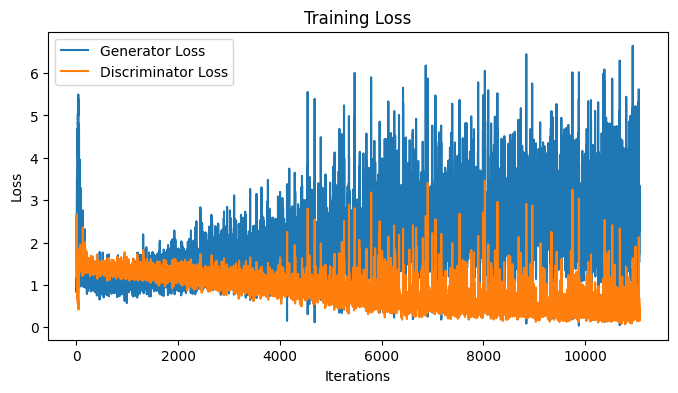

In [10]:
# Plot Losses
plt.figure(figsize=(8,4))
plt.title("Training Loss")
plt.plot(gen_losses,label="Generator Loss")
plt.plot(dis_losses,label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

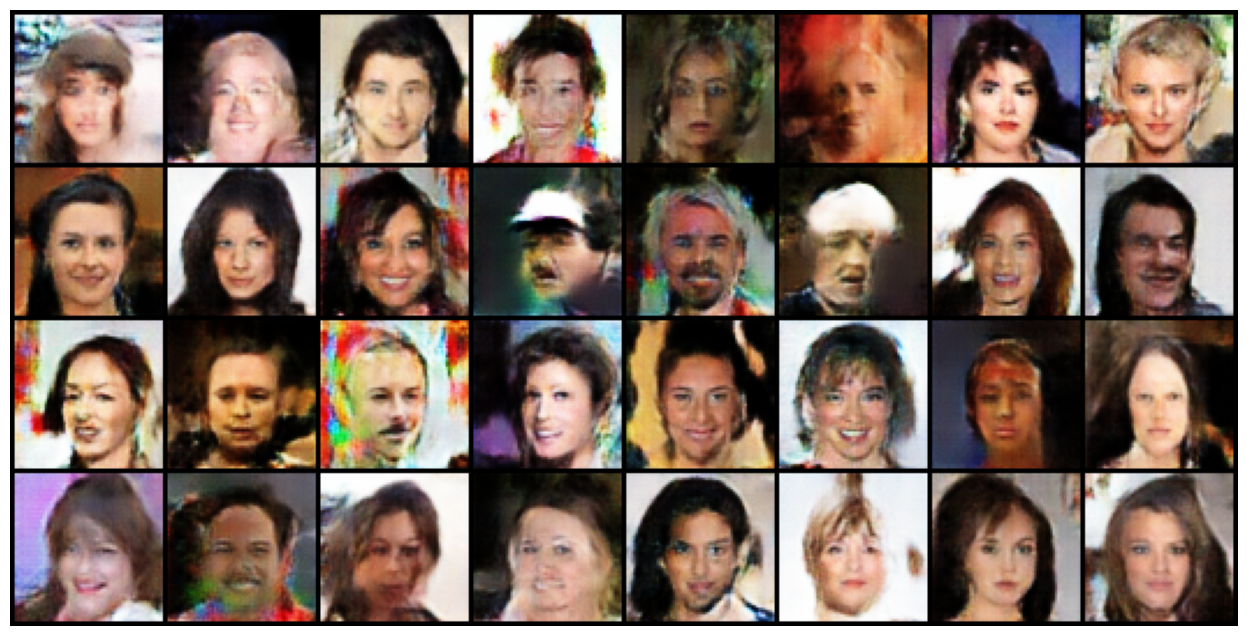

In [11]:
# Generate Images
noise = torch.randn(32, 100, 1, 1, device=device)
with torch.no_grad():
    generated = gen(noise).detach().cpu()
gen_imgs = vutils.make_grid(generated, padding=2, normalize=True)
# Plot the generated images
plt.figure(figsize=(16,8))
plt.axis("off")
plt.imshow(np.transpose(gen_imgs,(1,2,0)))
plt.show()